# Model Testing

We're going to see how the different models perform, and potentially check what features are most determinative.

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, HalvingGridSearchCV,PredefinedSplit
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score,classification_report,
                            confusion_matrix, ConfusionMatrixDisplay,
                            roc_auc_score)
from sklearn.svm import SVC
from time import time
import joblib
import os
os.chdir("/home/insert_user/GDELT_GKG")

In [3]:
#------------------------------------------------------------------------------
# IMPORT TRAINING, VALIDATION AND TEST SETS
#------------------------------------------------------------------------------

# let's define the class names already
global class_names
class_names = ["left","left center","least biased","right center","right"] # in order from MBFC mappings # ["left","center","right"]#

# get experiment name
dataset_extension = "_mbfc_allbias_extrafeatures" #

train = pd.read_csv("data/train{}.csv".format(dataset_extension))
train.set_index("outlet", inplace=True)

val = pd.read_csv("data/val{}.csv".format(dataset_extension))
val.set_index("outlet", inplace=True)

test = pd.read_csv("data/test{}.csv".format(dataset_extension))
test.set_index("outlet", inplace=True)

train.head()


,ACT_YIELD_PosScore,ACT_YIELD_article_count,AID_ECONOMIC_SelfRefDens,AID_ECONOMIC_article_count,ASSASSINATION_SelfRefDens,AVIATION_INCIDENT_article_count,BLACK_MARKET_NegScore,BULLYING_article_count,CEASEFIRE_PosScore,CHARASMATIC_LEADERSHIP_Polarity,...,SOC_EXCEPTIONALISM_article_count,DISCRIMINATION_IMMIGRATION_ULTRANATIONALISTS_SelfRefDens,lean,Factuality,PressFreedom,MediaType,Traffic,Credibility,Longitude,Latutude
outlet,,,,,,,,,,,,,,,,,,,,,
abqjournal.com,0.271539,0.283754,0.041574,0.119133,0.126767,0.201925,0.356804,0.099167,0.135127,0.371547,...,0.000000,0.032474,3,4,2,3,1,2,-100.445882,39.78373
denvergazette.com,0.417405,0.206508,0.024035,0.125236,0.080374,0.191042,0.544004,0.095412,0.169859,0.000000,...,0.000000,0.000000,3,4,2,7,1,2,-100.445882,39.78373
northkoreatimes.com,0.319925,0.304107,0.079288,0.221308,0.126076,0.098466,0.489759,0.074936,0.181789,0.000000,...,0.000000,0.263546,2,3,2,7,0,1,-100.445882,39.78373
journaltimes.com,0.322395,0.241716,0.051005,0.097725,0.296384,0.201251,0.448084,0.171241,0.136535,0.550394,...,0.000000,0.000000,2,4,2,3,1,2,-100.445882,39.78373
lubbockonline.com,0.000000,0.000000,0.000000,0.000000,0.483809,0.374809,0.000000,0.196105,0.231912,0.000000,...,0.078206,0.000000,3,4,2,3,1,2,-100.445882,39.78373


In [4]:
# split each dataset into X and y's
X_train = train.drop("lean", axis=1)
y_train = train["lean"]

X_val = val.drop("lean", axis=1)
y_val = val["lean"]

X_test = test.drop("lean", axis=1)
y_test = test["lean"]

In [5]:
print(X_train.shape,X_val.shape,X_test.shape)

(578, 364) (125, 364) (128, 364)


Let's make a new folder for each experiment so we can better keep track of everything.

In [6]:
if not os.path.exists("results/Experiment{}".format(dataset_extension)):
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs("results/Experiment{}".format(dataset_extension))
    print("Made Experiment Folder!")

os.chdir("results/Experiment{}".format(dataset_extension))

Made Experiment Folder!


## MODEL TRAINING

In [7]:
def get_PreDefinedSplit(X_train,y_train,X_val,y_val):
    """
    Since we're working with predetermined datasets, we need to do some fidddling to
    ensure our ML and DL models train, validate and test on the same things.
    
    Sklearn's HalvingGridSearch does the split itself, but we can specify out own split
    if we combine our two datasets and mark which one is training and which one is val.
    """
    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    
    return X,y,PredefinedSplit(split_index)
    

In [8]:
def get_AUC_scores(y_test,y_pred):
    """
    Since we need to use OneHotEncoded values for AUC, we'll do that here separately.
    We also calculate the AUC per class, and also its average. Then put this in
    array and pad it so it fits into the report DataFrame.
    """
    ohe = OneHotEncoder()
    out = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()
    y_test_ohe = pd.DataFrame(out, index=y_test.index)
    # get same shape for predictions
    out = ohe.transform(y_pred.reshape(-1, 1)).toarray()
    y_pred_ohe = pd.DataFrame(out, index=y_test.index)
    
    # compute actual scores
    AUC_avg = roc_auc_score(y_test_ohe,y_pred_ohe, multi_class='ovr')
    AUC_per_class = roc_auc_score(y_test_ohe,y_pred_ohe, average=None,multi_class='ovr')
    # add AUC to report DF
    AUC_list = np.append(AUC_per_class,AUC_avg)
    AUC_list = np.append(AUC_list, [0,0]) # add padding so it fits into DF
    
    return AUC_list

In [9]:
def evaluate_predictions(y_test,y_pred,save=True,model_name=""):
    # make report of predictions
    report = pd.DataFrame(classification_report(y_test,y_pred, output_dict=True,))
    # get AUC score & add to report DF
    report.loc['AUC',:] = get_AUC_scores(y_test,y_pred)
    
    # make confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
            y_test,
            y_pred,
            display_labels = class_names,
            xticks_rotation="vertical",
            cmap=plt.cm.Blues,
        )
    disp.ax_.set_title("{} Confusion Matrix of Outlet Bias".format(model_name))
    # print results and timing
    print("Test accuracy")
    print(f"{accuracy_score(y_test, y_pred):.2%}\n")

    if save == True:
        # save picture and report
        save_path_confmx = "{}_Confusion_Matrix{}.png".format(model_name,dataset_extension)
        save_path_report = "{}_Report{}.csv".format(model_name,dataset_extension)
        # picture
        disp.figure_.savefig(save_path_confmx)
        report.to_csv(save_path_report)

    return report,disp

In [10]:
#------------------------------------------------------------------------------
# MODEL TRAINING FUNCTION
#------------------------------------------------------------------------------

def train_model_pipeline(model, param_grid, 
                         X_train, y_train, 
                         X_val, y_val,
                         X_test, y_test,
                         model_name="", 
                         labels=class_names, 
                         verbose=1,
                         save=True):
    """
    Quick function for performing grid search of various sklearn models. The
    function then prints results, makes a confusion matrix plot and prints how
    long it took to do the above.
    
    The confusion matrix and results are saved in the results folder.
    
    Returns: 
        report -- (DataFrame)  Report of performance metrics from sklearn.
        clf    -- (object)     sklearn model trained with the best parameters 
                               determined from grid search.
        disp   -- (object)     Confusion Matrix plot
    """
    # start timer
    start = time()
    # set predefined validation to be used in Grid Search
    X,y,pre_split = get_PreDefinedSplit(X_train=X_train,y_train=y_train,
                                    X_val=X_val,y_val=y_val)
    
    # do Grid Search for all parameters to find best model
    sh = HalvingGridSearchCV(model, param_grid, factor=2, cv=pre_split,
                              aggressive_elimination=False,
                              n_jobs=-1, # parallel jobs with jobil
                              verbose=verbose).fit(X, y)
    # fit best estimated model
    clf = sh.best_estimator_.fit(X_train,y_train)
    print("The best model had the following parameters: {}".format(sh.best_estimator_))
    
    # get predictions
    y_pred = clf.predict(X_test)
    # evaluate
    report,disp = evaluate_predictions(y_test=y_test,
                                       y_pred=y_pred,
                                       save=save,
                                       model_name=model_name)
    end = time()
    print("This took {} s.".format(end-start))
    
    return report, clf, disp

## DUMMY MODEL

The best model had the following parameters: DummyClassifier(strategy='most_frequent')
Test accuracy
46.88%

This took 0.6447854042053223 s.


/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.468750,0.0,0.0,0.46875,0.09375,0.219727
recall,0.0,0.0,1.000000,0.0,0.0,0.46875,0.20000,0.468750
f1-score,0.0,0.0,0.638298,0.0,0.0,0.46875,0.12766,0.299202
support,7.0,36.0,60.000000,18.0,7.0,0.46875,128.00000,128.000000
AUC,0.5,0.5,0.500000,0.5,0.5,0.50000,0.00000,0.000000


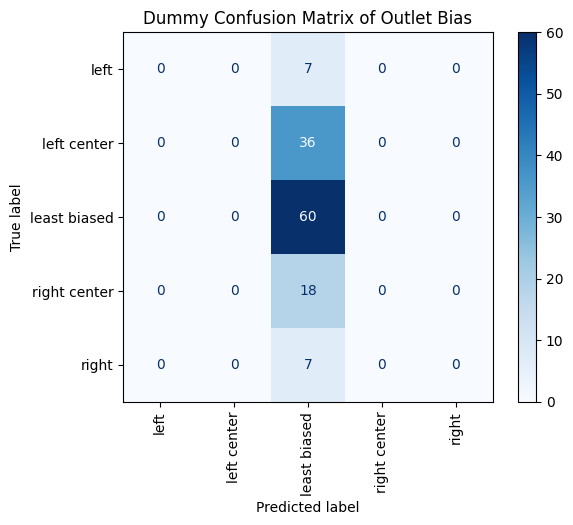

In [11]:
from sklearn.dummy import DummyClassifier

param_grid = {
    "strategy": ["most_frequent"]
}

dummy = DummyClassifier()

dummy_results,best_dummy,dummy_disp = train_model_pipeline(model=dummy, param_grid=param_grid, 
                             X_train=X_train, y_train=y_train, 
                             X_val=X_val, y_val=y_val,
                             X_test=X_test, y_test=y_test,
                             model_name="Dummy", verbose=0)

dummy_results.head()

#dummy_clf = DummyClassifier(strategy="most_frequent")
#dummy_clf.fit(X, y)
#dummy_clf.predict(X)
#dummy_clf.score(X, y)

## ACTUAL MODELS

The best model had the following parameters: SVC(C=5, degree=10, gamma=0.1, probability=True)
Test accuracy
75.00%

This took 5.121690034866333 s.


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,1.000000,0.585366,0.843750,0.666667,1.000000,0.750000,0.819157,0.763267
recall,0.428571,0.666667,0.900000,0.555556,0.714286,0.750000,0.653016,0.750000
f1-score,0.600000,0.623377,0.870968,0.606061,0.833333,0.750000,0.706748,0.747203
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.750000,128.000000,128.000000
AUC,0.714286,0.740942,0.876471,0.755051,0.857143,0.788778,0.000000,0.000000


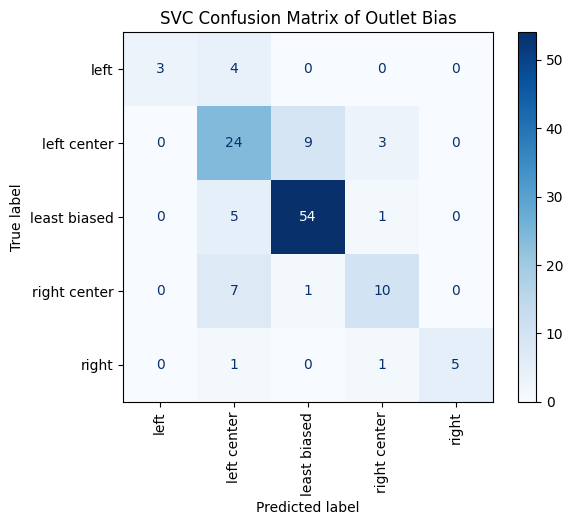

In [12]:
#------------------------------------------------------------------------------
# MAKE SUPPORT VECTOR CLASSIFER
#------------------------------------------------------------------------------

param_grid = {
    "C": [0.01,0.1,2,4,5,10],
    "gamma": [0.1,0.01,0.001],
    "kernel": ["rbf","poly","linear"],
    "degree":[1,2,3,4,5,10],
    "break_ties":[True,False],
    "class_weight":["balanced",None]
},

svc_clf = SVC(gamma="scale",probability=True)

svc_results,best_svc,svc_disp = train_model_pipeline(model=svc_clf, param_grid=param_grid, 
                             X_train=X_train, y_train=y_train, 
                             X_val=X_val, y_val=y_val,
                             X_test=X_test, y_test=y_test,
                             model_name="SVC", verbose=0)

svc_results.head()

In [13]:
joblib.dump(best_svc, "best_SVC_model_{}.sav".format(dataset_extension))
#svc_disp.figure_.savefig("best_SVC_CM_{}.png".format(dataset_extension))
#svc_results.to_csv("best_SVC_report_{}.csv".format(dataset_extension))

['best_SVC_model__mbfc_allbias_extrafeatures.sav']

The best model had the following parameters: RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       max_leaf_nodes=50, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=10, random_state=0)
Test accuracy
64.06%

This took 200.7691605091095 s.


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,1.000000,0.600000,0.650602,0.333333,0.833333,0.640625,0.683454,0.620855
recall,0.428571,0.500000,0.900000,0.111111,0.714286,0.640625,0.530794,0.640625
f1-score,0.600000,0.545455,0.755245,0.166667,0.769231,0.640625,0.567319,0.605747
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.640625,128.000000,128.000000
AUC,0.714286,0.684783,0.736765,0.537374,0.853011,0.705243,0.000000,0.000000


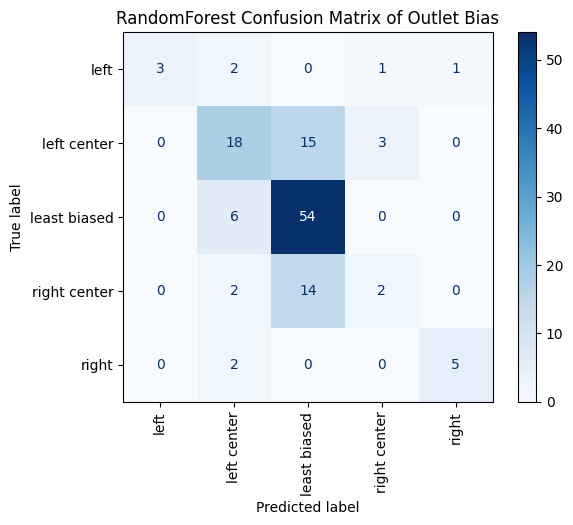

In [14]:
#------------------------------------------------------------------------------
# MAKE RANDOM FOREST
#------------------------------------------------------------------------------

param_grid = {
    "n_estimators": [10,50,100],
    "criterion": ["gini","entropy","log_loss"],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [5,10,20,50],
    "max_features":["sqrt","log2",None,10,100],
    "max_leaf_nodes":[5,10,20,50,None],
    "bootstrap": [True,False],
    "warm_start": [True,False]
}

rand_clf = RandomForestClassifier(random_state=0)

rf_results,best_rf,rf_disp = train_model_pipeline(model=rand_clf, param_grid=param_grid, 
                             X_train=X_train, y_train=y_train, 
                             X_val=X_val, y_val=y_val,
                             X_test=X_test, y_test=y_test,
                             model_name="RandomForest",
                             verbose=0)
rf_results.head()

In [15]:
joblib.dump(best_rf, "best_RF_model_{}.sav".format(dataset_extension))
#rf_disp.figure_.savefig("best_RF_CM_{}.png".format(dataset_extension))
#rf_results.to_csv("best_RF_report_{}.csv".format(dataset_extension))

['best_RF_model__mbfc_allbias_extrafeatures.sav']

The best model had the following parameters: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=1000, min_samples_leaf=3,
                       random_state=0)
Test accuracy
61.72%

This took 74.06258153915405 s.


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.444444,0.576923,0.753846,0.318182,0.666667,0.617188,0.552012,0.621133
recall,0.571429,0.416667,0.816667,0.388889,0.571429,0.617188,0.553016,0.617188
f1-score,0.500000,0.483871,0.784000,0.350000,0.615385,0.617188,0.546651,0.613805
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.617188,128.000000,128.000000
AUC,0.765053,0.648551,0.790686,0.626263,0.777450,0.721601,0.000000,0.000000


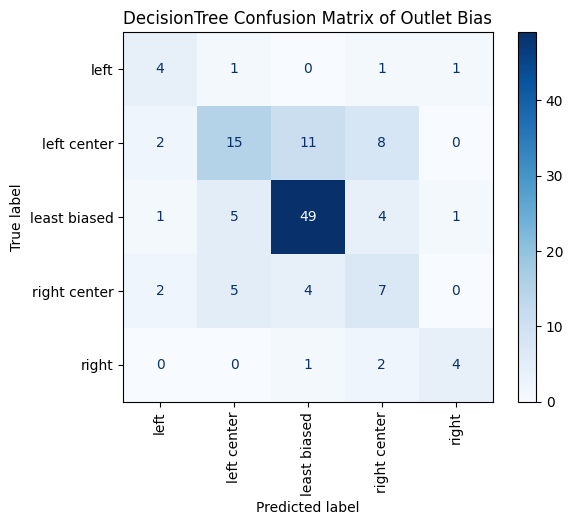

In [16]:
#------------------------------------------------------------------------------
# MAKE DECISION TREE
#------------------------------------------------------------------------------

param_grid = {
    "criterion":["gini", "entropy", "log_loss"],
    "splitter":["best","random"],
    "max_depth":[None,3,5,10,50,100],
    "min_samples_split":[2,5,50,100,500],
    "min_samples_leaf":[1,3,5,10,50],
    "max_features":["sqrt","log2",None,10,100,500,1000,2000],
    "max_leaf_nodes":[5,10,20,50,None],
    "class_weight":["balanced",None]
}

tree_clf = DecisionTreeClassifier(random_state=0)

tree_results,best_tree,tree_disp = train_model_pipeline(model=tree_clf, param_grid=param_grid, 
                                 X_train=X_train, y_train=y_train, 
                                 X_val=X_val, y_val=y_val,
                                 X_test=X_test, y_test=y_test,
                                 model_name="DecisionTree",
                                 verbose=0)
tree_results.head()

In [17]:
joblib.dump(best_tree, "best_tree_model_{}.sav".format(dataset_extension))
#tree_disp.figure_.savefig("best_tree_CM_{}.png".format(dataset_extension))
#tree_results.to_csv("best_tree_report_{}.csv".format(dataset_extension))

['best_tree_model__mbfc_allbias_extrafeatures.sav']

The best model had the following parameters: AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                    max_depth=5),
                   learning_rate=2, n_estimators=10, random_state=0)
Test accuracy
75.00%

This took 12.07356071472168 s.


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.666667,0.622222,0.864407,0.625000,1.000000,0.750000,0.755659,0.759227
recall,0.285714,0.777778,0.850000,0.555556,0.714286,0.750000,0.636667,0.750000
f1-score,0.400000,0.691358,0.857143,0.588235,0.833333,0.750000,0.674014,0.746399
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.750000,128.000000,128.000000
AUC,0.638725,0.796498,0.866176,0.750505,0.857143,0.781809,0.000000,0.000000


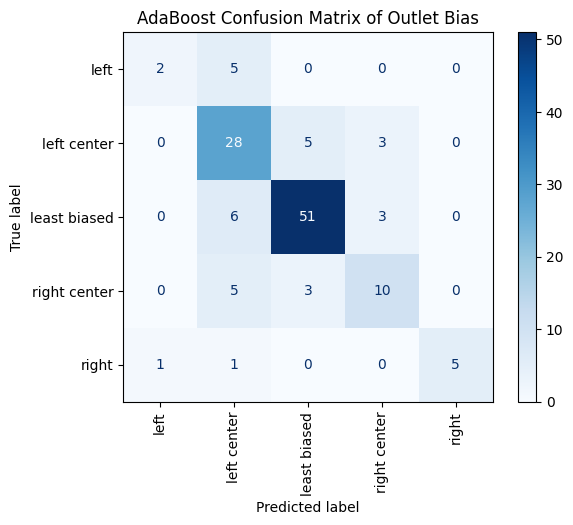

In [18]:
#------------------------------------------------------------------------------
# MAKE ADABOOST
#------------------------------------------------------------------------------

param_grid = {"estimator": [DecisionTreeClassifier(max_depth=1, 
                                                   min_samples_leaf=1,
                                                   class_weight="balanced"),
                            DecisionTreeClassifier(max_depth=3, 
                                                   min_samples_leaf=1,
                                                   class_weight="balanced"),
                            DecisionTreeClassifier(max_depth=5, 
                                                   min_samples_leaf=1,
                                                   class_weight="balanced"),
                            RandomForestClassifier(max_depth=1, 
                                                   min_samples_leaf=1,
                                                   class_weight="balanced"),
                            RandomForestClassifier(max_depth=3, 
                                                   min_samples_leaf=1,
                                                   class_weight="balanced"),
                            RandomForestClassifier(max_depth=5, 
                                                   min_samples_leaf=1,
                                                   class_weight="balanced")],
             "n_estimators": [5,10,50],
             "learning_rate": [0.001,0.01,0.1,0.2,0.5,1,2],
             }

ada_clf = AdaBoostClassifier(random_state=0)

ada_results,best_ada,ada_disp = train_model_pipeline(model=ada_clf, param_grid=param_grid, 
                             X_train=X_train, y_train=y_train, 
                             X_val=X_val, y_val=y_val,
                             X_test=X_test, y_test=y_test,
                             model_name="AdaBoost",
                             verbose=0)
ada_results.head()

In [19]:
joblib.dump(best_ada, "best_ADA_model_{}.sav".format(dataset_extension))
#ada_disp.figure_.savefig("best_ADA_CM_{}.png".format(dataset_extension))
#ada_results.to_csv("best_ADA_report_{}.csv".format(dataset_extension))

['best_ADA_model__mbfc_allbias_extrafeatures.sav']

The best model had the following parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=3, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
Test accuracy
64.84%

This took 2.4674787521362305 s.


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.000000,0.567568,0.757576,0.500000,0.500000,0.648438,0.465029,0.612398
recall,0.000000,0.583333,0.833333,0.444444,0.571429,0.648438,0.486508,0.648438
f1-score,0.000000,0.575342,0.793651,0.470588,0.533333,0.648438,0.474583,0.629182
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.648438,128.000000,128.000000
AUC,0.495868,0.704710,0.799020,0.685859,0.769185,0.690928,0.000000,0.000000


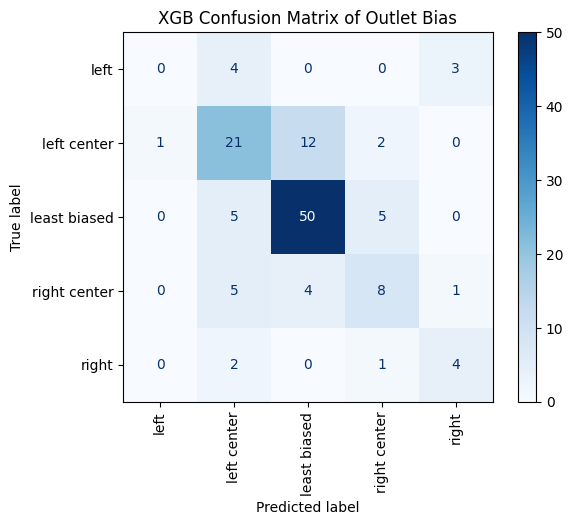

In [20]:
#------------------------------------------------------------------------------
# MAKE XGBOOST 
#------------------------------------------------------------------------------

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [3,5,10,50],
    #"max_depth": [3,5,10],
    #"max_leaves": [1,5],#10,50],
    #"grow_policy": [0,1],
    "learning_rate": [0.1,0.01,0.05],
    #"booster": ["gbtree", "gblinear","dart"],
    #"gamma": [0,0.25,1],
    #"reg_alpha": [0,0.1,0.5,1.10],
    #"reg_lambda": [0,0.1,0.5,1,10],
    #"scale_pos_weight": [1, 3, 5],
    #"subsample": [0.8],
    #"colsample_bytree": [0.5],
}

xgb_clf = xgb.XGBClassifier(objective="multi:softprob",random_state=0)

# recode categorical y to numeric
y_train_num = y_train.replace({"left":0,"center":1,"right":2})
y_val_num = y_val.replace({"left":0,"center":1,"right":2})
y_test_num = y_test.replace({"left":0,"center":1,"right":2})

xgb_results,best_xgb,xgb_disp = train_model_pipeline(model=xgb_clf, param_grid=param_grid, 
                                     X_train=X_train, y_train=y_train_num,
                                     X_val=X_val, y_val=y_val_num,
                                     X_test=X_test, y_test=y_test_num,
                                     model_name="XGB",verbose=0,labels=[0,1,2])

#best_xgb.save_model("XGB_6758.json")

xgb_results.head()

In [21]:
joblib.dump(best_xgb, "best_XGB_model_{}.sav".format(dataset_extension))
#xgb_disp.figure_.savefig("best_XGB_CM_{}.png".format(dataset_extension))
#xgb_results.to_csv("best_XGB_report_{}.csv".format(dataset_extension))

['best_XGB_model__mbfc_allbias_extrafeatures.sav']

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 337, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 472, in _fit
    all_results = Para

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.         0.                nan ... 0.66666667 0.66666667 0.66666667]
  warnings.warn(
/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [0.125  0.125     nan ... 0.375  1.     0.8125]
  warnings.warn(
/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.         0.                nan ... 0.5        0.66666667 0.66666667]
  warnings.warn(
/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [0.125      0.125             nan ... 0.93939394 1.         1.        ]
  warnings.warn(
/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_search

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.         0.                nan ... 0.58823529 0.61764706 0.61764706]
  warnings.warn(
/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the train scores are non-finite: [0.125      0.125             nan ... 0.99441341 0.98324022 0.98324022]
  warnings.warn(
/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
  

The best model had the following parameters: BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
     

/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.666667,0.676471,0.753623,0.625000,0.833333,0.718750,0.711019,0.713440
recall,0.285714,0.638889,0.866667,0.555556,0.714286,0.718750,0.612222,0.718750
f1-score,0.400000,0.657143,0.806202,0.588235,0.769231,0.718750,0.644162,0.709391
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.718750,128.000000,128.000000
AUC,0.638725,0.759662,0.808333,0.750505,0.853011,0.762047,0.000000,0.000000


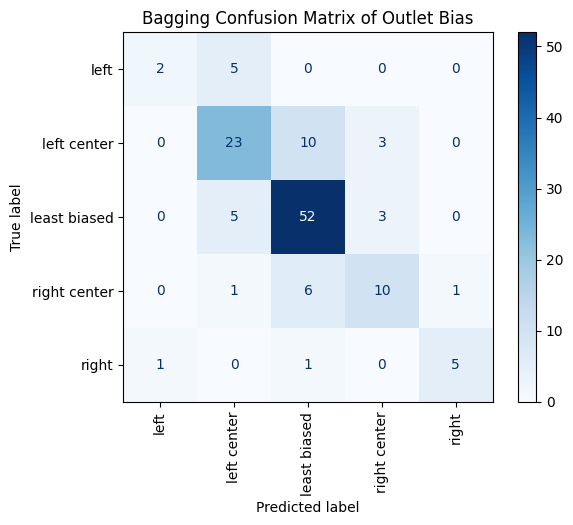

In [22]:
#------------------------------------------------------------------------------
# MAKE BAGGING CLASSIFIER
#------------------------------------------------------------------------------

from sklearn.ensemble import BaggingClassifier

param_grid = {
    "estimator":[best_svc,best_tree,best_rf,best_ada,best_xgb],
    "n_estimators":[5,10,20,50,100],
    "max_features":[0.2,0.5,0.8,1.0],
    "bootstrap":[True,False],
    "bootstrap_features":[True,False],
    "warm_start":[True,False],
}

bag_clf = BaggingClassifier(random_state=0)

bag_results,best_bag,bag_disp = train_model_pipeline(model=bag_clf, param_grid=param_grid, 
                     X_train=X_train, y_train=y_train, 
                     X_val=X_val, y_val=y_val,
                     X_test=X_test, y_test=y_test,
                     model_name="Bagging",verbose=0)

bag_results.head()

In [23]:
joblib.dump(best_bag, "best_Bagging_model_{}.sav".format(dataset_extension))
#bag_disp.figure_.savefig("best_Bagging_CM_{}.png".format(dataset_extension))
#bag_results.to_csv("best_Bagging_report_{}.csv".format(dataset_extension))

['best_Bagging_model__mbfc_allbias_extrafeatures.sav']

## LINEAR DISCRIMINANT ANALYSIS

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 87
max_resources_: 703
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 87
Fitting 1 folds for each of 9 candidates, totalling 9 fits
----------
iter: 1
n_candidates: 5
n_resources: 174
Fitting 1 folds for each of 5 candidates, totalling 5 fits
----------
iter: 2
n_candidates: 3
n_resources: 348
Fitting 1 folds for each of 3 candidates, totalling 3 fits
----------
iter: 3
n_candidates: 2
n_resources: 696
Fitting 1 folds for each of 2 candidates, totalling 2 fits


/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 631, in fit
    self._solve_eigen(
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/discriminant_analysis.py", line 463, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/home/ronja/

The best model had the following parameters: LinearDiscriminantAnalysis(n_components=3)
Test accuracy
52.34%

This took 0.592958927154541 s.


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.400000,0.472222,0.750000,0.241379,0.500000,0.523438,0.472720,0.567538
recall,0.285714,0.472222,0.600000,0.388889,0.714286,0.523438,0.492222,0.523438
f1-score,0.333333,0.472222,0.666667,0.297872,0.588235,0.523438,0.471666,0.537599
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.523438,128.000000,128.000000
AUC,0.630460,0.632850,0.711765,0.594444,0.836482,0.681200,0.000000,0.000000


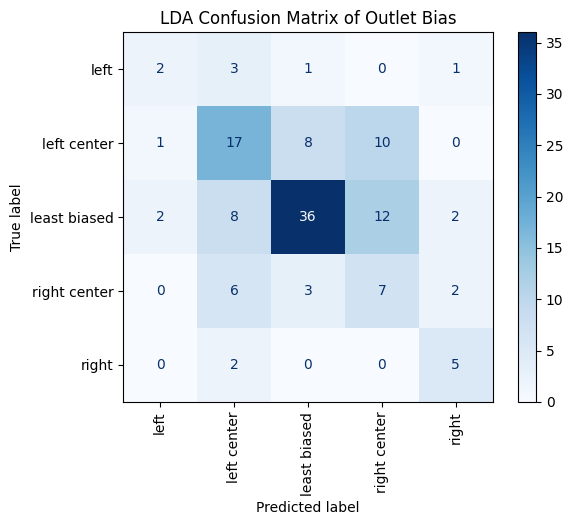

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

param_grid = {
    "solver":["svd","lsqr","eigen"],
    "n_components": [2,3,4],
}

LDA_clf = LDA()

lda_results,best_lda,lda_disp = train_model_pipeline(model=LDA_clf, param_grid=param_grid, 
                     X_train=X_train, y_train=y_train, 
                     X_val=X_val, y_val=y_val,
                     X_test=X_test, y_test=y_test,
                     model_name="LDA",verbose=1, save=False)

lda_results.head()

### LDA Features

In [25]:
components = 3

# fit LDA
lda = LDA(n_components=components)
fit = lda.fit(X_train, y_train)
# get coefficients in shape (n_classes, n_features)
LDA_coefficients = pd.DataFrame(fit.coef_, columns=X_train.columns)
# summarize components
print("Explained Variance: %s" % fit.explained_variance_ratio_)
#print(LDA_coefficients)

# transform
#LDA_X_train = fit.transform(X_train)
#LDA_X_val = fit.transform(X_val)
#LDA_X_test = fit.transform(X_test)

Explained Variance: [0.39939098 0.3588921  0.12826994]


In [26]:
def make_df(X,fit,names_list):
    LDA_X = fit.transform(X)
    LDA_X = pd.DataFrame(LDA_X, columns=names_list)
    LDA_X["outlet"] = X.index
    LDA_X.set_index("outlet", inplace=True)
    return LDA_X

# make into new dfs
names_list = ["C{}".format(i) for i in range(components)]

LDA_X_train = make_df(X_train,fit,names_list)
LDA_X_val = make_df(X_val,fit,names_list)
LDA_X_test = make_df(X_test,fit,names_list)

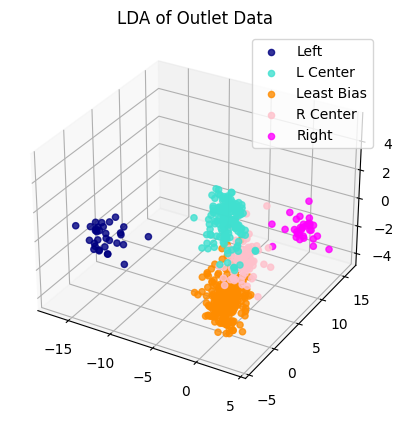

In [27]:
# 3D PLOTTING

def plot_true_clusters(LDA_X,y):
    colors = ["navy", "turquoise", "darkorange","pink", "magenta"]
    target_names = ["Left", "L Center", "Least Bias", "R Center", "Right"]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for color, i, target_name in zip(colors, [0,1,2,3,4], target_names):
        ax.scatter(
            LDA_X.loc[y == i,"C0"], 
            LDA_X.loc[y == i,"C1"], 
            LDA_X.loc[y == i,"C2"],
            alpha=0.8, color=color, label=target_name
        )
    ax.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("LDA of Outlet Data")
    
plot_true_clusters(LDA_X_train,y_train)

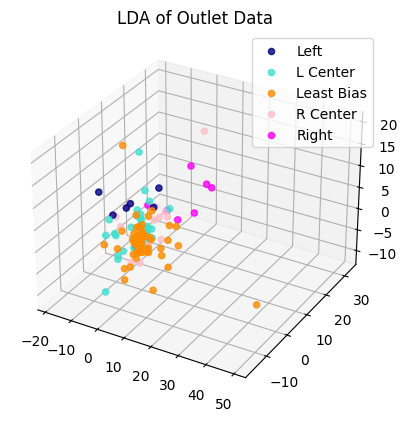

In [28]:
    
plot_true_clusters(LDA_X_test,y_test)

## Classify on LDA with Classifiers

The best model had the following parameters: BaggingClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.05, max_bin=None,
                                          max_cat_threshold=None,
     

/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,1.000000,0.585366,0.843750,0.666667,1.000000,0.750000,0.819157,0.763267
recall,0.428571,0.666667,0.900000,0.555556,0.714286,0.750000,0.653016,0.750000
f1-score,0.600000,0.623377,0.870968,0.606061,0.833333,0.750000,0.706748,0.747203
support,7.000000,36.000000,60.000000,18.000000,7.000000,0.750000,128.000000,128.000000
AUC,0.714286,0.740942,0.876471,0.755051,0.857143,0.788778,0.000000,0.000000


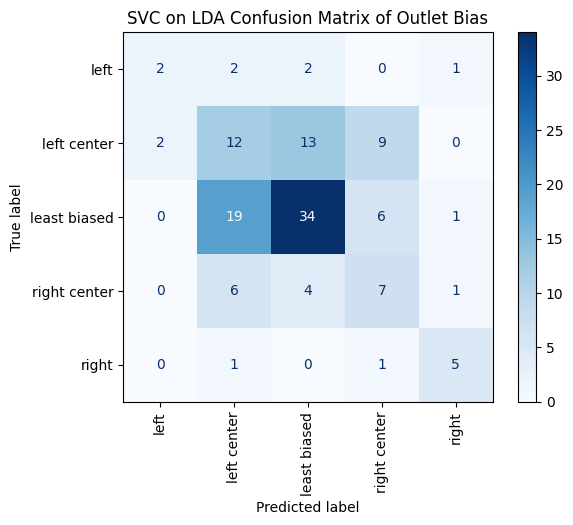

In [29]:
#------------------------------------------------------------------------------
# MAKE SUPPORT VECTOR CLASSIFER
#------------------------------------------------------------------------------

param_grid = {
    "C": [0.01,0.1,2,4,5,10],
    "gamma": [0.1,0.01,0.001],
    "kernel": ["rbf","poly","linear"],
    "degree":[1,2,3,4,5,10],
    "break_ties":[True,False],
    "class_weight":["balanced",None]
},

param_grid  = {}

clf = best_bag

start = time()
svc_LDA_results,best_LDA_svc,svc_LDA_disp = train_model_pipeline(model=clf, param_grid=param_grid, 
                             X_train=LDA_X_train, y_train=y_train_num, 
                             X_val=LDA_X_val, y_val=y_val_num,
                             X_test=LDA_X_test, y_test=y_test_num,
                             model_name="SVC on LDA", verbose=0,labels=[0,1,2])
end = time()
print("This took: ", end-start)
svc_results.head()

In [30]:
joblib.dump(best_LDA_svc, "best_LDA_model_{}.sav".format(dataset_extension))
#svc_LDA_disp.figure_.savefig("best_LDA_CM_{}.png".format(dataset_extension))
#svc_LDA_results.to_csv("best_LDA_report_{}.csv".format(dataset_extension))

['best_LDA_model__mbfc_allbias_extrafeatures.sav']

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/base.py", line 668, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 827, in predict
    predicted_probabilitiy = self.predict_proba(X)
  File "/home/ronja/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 865, in predict

# Get Performances

In [32]:
os.chdir("..")

In [33]:
os.listdir()

['Experiment_robertson5_otherbias',
 'Experiment_mbfc_allbias',
 'Experiment_mbfc_allbias_extrafeatures',
 'Experiment_robertson5_wordbias',
 'Experiment_robertson5_allbias',
 'Experiment_mbfc_otherbias',
 '.ipynb_checkpoints',
 'OLD',
 'Experiment_mbfc_wordbias',
 'Experiment_mbfc_allbias_include_categorical']

In [100]:
experiment_folder = "Experiment_mbfc_allbias_extrafeatures"

dfs = {}
for file in os.listdir(experiment_folder):
    if file.endswith(".csv"):
        df = pd.read_csv(experiment_folder + "/" +file)
        name = file[:3]
        dfs[name] = df
        

# Get model summary

In [110]:
experiment_folder = "Experiment_mbfc_allbias"

best_ada_model = joblib.load(experiment_folder + "/" + "best_ADA_model__mbfc_allbias.sav")

In [111]:
best_ada_model

AdaBoostClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                    max_depth=5),
                   learning_rate=2, random_state=0)

In [112]:
best_ada_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 5,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(class_weight='balanced', max_depth=5),
 'learning_rate': 2,
 'n_estimators': 50,
 'random_state': 0}